In [ ]:
# TODO: something weird with output dimensions, too high, not discretized properly, vocab size is too high

In [187]:
import numpy as np

def generate_waveforms(num_sequences, sequence_length, num_modes, freq_range, amp_range, phase_range):
    """
    Generates a dataset of continuous waveforms, each composed of a sum of sinusoidal modes.
    Parameters:
    - num_sequences (int): Number of waveform sequences to generate.
    - sequence_length (int): Number of samples in each waveform sequence.
    - num_modes (int): Number of sinusoidal modes per sequence.
    - freq_range (tuple): Range of frequencies (min_freq, max_freq).
    - amp_range (tuple): Range of amplitudes (min_amp, max_amp).
    - phase_range (tuple): Range of phases (min_phase, max_phase).
    Returns:
    - np.array: Array of shape (num_sequences, sequence_length) containing the generated continuous waveforms.
    """
    waveforms = np.zeros((num_sequences, sequence_length))
    t = np.linspace(0, 2 * np.pi, sequence_length, endpoint=False)
    for i in range(num_sequences):
        for _ in range(num_modes):
            frequency = np.random.uniform(*freq_range)
            amplitude = np.random.uniform(*amp_range)
            phase = np.random.uniform(*phase_range)
            waveforms[i] += amplitude * np.sin(frequency * t + phase)
    return waveforms  # Shape: (num_sequences, sequence_length)

def discretize_waveforms(waveforms, num_bins):
    """
    Discretizes continuous waveforms into one-hot encoded bins after scaling.
    Parameters:
    - waveforms (np.array): Array of continuous waveforms (num_sequences, sequence_length).
    - num_bins (int): Number of bins for discretizing continuous values.
    Returns:
    - np.array: Array of shape (num_sequences, sequence_length, num_bins) containing one-hot encoded waveforms.
    """
    # Normalize the waveform values to [0, num_bins - 1]
    min_val, max_val = waveforms.min(), waveforms.max()
    scaled_waveforms = (waveforms - min_val) / (max_val - min_val) * (num_bins - 1)

    # Discretize to integer bins, ensuring values stay within [0, num_bins - 1]
    discretized_waveforms = np.clip(np.round(scaled_waveforms), 0, num_bins - 1).astype(int)
    
    # Convert to one-hot encoding
    one_hot_waveforms = np.eye(num_bins)[discretized_waveforms]
    
    return one_hot_waveforms  # Shape: (num_sequences, sequence_length, num_bins)


In [188]:
import numpy as np

# Parameters for waveform generation
num_sequences = 1024       # Number of sequences
sequence_length = 128       # Length of each sequence
num_modes = 20              # Number of sinusoidal components
freq_range = (1, 5)         # Frequency range for components
amp_range = (0.5, 1.5)      # Amplitude range for components
phase_range = (0, 2 * np.pi)  # Phase range

# Generate continuous waveforms
waveforms = generate_waveforms(num_sequences, sequence_length, num_modes, freq_range, amp_range, phase_range)

# Discretize waveforms into tokens
num_bins = 32  # Number of bins for tokenizing
discretized_waveforms = discretize_waveforms(waveforms, num_bins)
print("Discretized waveform shape:", discretized_waveforms.shape)

# Convert one-hot encoding to integer tokens
token_sequences = np.argmax(discretized_waveforms, axis=-1)  # Shape: (num_sequences, sequence_length)
print("Token sequences shape:", token_sequences.shape)



Discretized waveform shape: (1024, 128, 32)
Token sequences shape: (1024, 128)


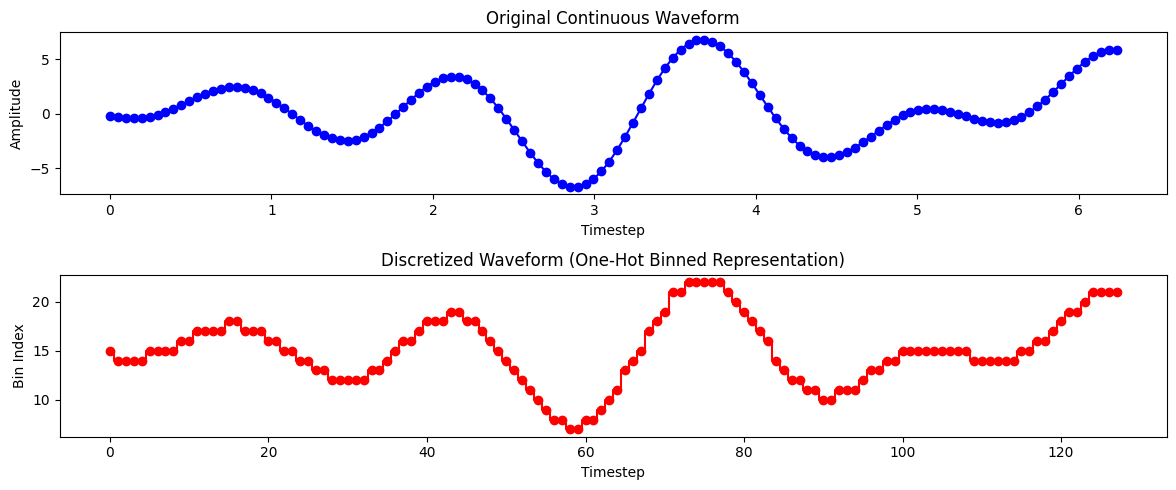

In [189]:
from matplotlib import pyplot as plt
# Extract the continuous waveform and the discretized one-hot version
continuous_waveform = waveforms[0]  # Shape (sequence_length,)
discretized_waveform = np.argmax(discretized_waveforms[0], axis=1)  # Get bin indices for plotting

# Plot the original continuous waveform
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(np.linspace(0, 2 * np.pi, sequence_length, endpoint=False), continuous_waveform, color='b', marker='o')
plt.title("Original Continuous Waveform")
plt.xlabel("Timestep")
plt.ylabel("Amplitude")

# Plot the discretized one-hot waveform
plt.subplot(2, 1, 2)
plt.step(range(sequence_length), discretized_waveform, where='mid', color='r', marker='o')
plt.title("Discretized Waveform (One-Hot Binned Representation)")
plt.xlabel("Timestep")
plt.ylabel("Bin Index")

plt.tight_layout()

In [190]:
# Step 1: Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Any, List

In [191]:
from lit_gpt import Config  # Update with correct import path if needed

# Define a smaller configuration
config = Config(
    block_size=128,        # Shorter sequence length for simpler data
    n_layer=4,             # Fewer layers to fit on a single GPU
    n_head=4,              # Fewer attention heads
    n_embd=128,            # Smaller embedding dimension
    rotary_percentage=1.0, # Full rotary embedding for temporal data
    mamba=True,            # Use Mamba for hybrid SSM-attention
    norm_eps=1e-5,
    intermediate_size=256  # Small intermediate size for efficiency
)

In [192]:
# Import and initialize the GPT model
from lit_gpt import GPT  # Update path if needed

# Initialize the model with the custom config
model = GPT(config)

# Print model summary to confirm initialization
print(model)

GPT(
  (lm_head): Linear(in_features=128, out_features=50688, bias=False)
  (transformer): ModuleDict(
    (wte): Embedding(50688, 128)
    (h): ModuleList(
      (0-3): 4 x MBlock(
        (mixer): Mamba(
          (in_proj): Linear(in_features=128, out_features=512, bias=False)
          (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
          (act): SiLU()
          (x_proj): Linear(in_features=256, out_features=40, bias=False)
          (dt_proj): Linear(in_features=8, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=128, bias=False)
        )
        (norm): RMSNorm()
      )
    )
    (ln_f): RMSNorm()
  )
)


In [193]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert token sequences to PyTorch tensors
token_sequences_tensor = torch.tensor(token_sequences, dtype=torch.long)

# Define Dataset
dataset = TensorDataset(token_sequences_tensor)

# Split dataset into training and testing sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define DataLoaders for training and testing
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}")


Training samples: 819, Testing samples: 205


In [194]:
def train(model: nn.Module, data_loader: DataLoader, num_epochs: int = 10, lr: float = 1e-3) -> None:
    """
    Train the model on tokenized waveform data with shape assertions and labeled sizes.
    
    Args:
        model (nn.Module): Model to be trained.
        data_loader (DataLoader): Data loader providing input batches.
        num_epochs (int): Number of training epochs.
        lr (float): Learning rate.
    """
    # Move the model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Define sizes for readability
    vocab_size = model.config.padded_vocab_size  # Vocabulary size for model output
    seq_len = data_loader.dataset[0][0].shape[0]  # Sequence length from dataset

    model.train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # Cross-entropy for token prediction

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, batch in enumerate(data_loader):
            batch_size = batch[0].shape[0]  # Update batch size for last batch

            tokens = batch[0].to(device)  # Move tokens to GPU
            assert tokens.shape == (batch_size, seq_len), f"Expected tokens of shape ({batch_size}, {seq_len}), got {tokens.shape}"
            
            optimizer.zero_grad()
            
            # Forward pass
            inputs, targets = tokens[:, :-1], tokens[:, 1:]  # Predict next token
            truncated_seq_len = seq_len - 1
            assert inputs.shape == (batch_size, truncated_seq_len), f"Expected inputs shape ({batch_size}, {truncated_seq_len}), got {inputs.shape}"
            assert targets.shape == (batch_size, truncated_seq_len), f"Expected targets shape ({batch_size}, {truncated_seq_len}), got {targets.shape}"
            
            # Model output
            outputs = model(inputs)
            assert outputs.shape == (batch_size, truncated_seq_len, vocab_size), \
                f"Expected outputs shape ({batch_size}, {truncated_seq_len}, {vocab_size}), got {outputs.shape}"
            
            # Compute loss
            reshaped_outputs = outputs.reshape(-1, vocab_size)
            reshaped_targets = targets.reshape(-1)
            expected_reshaped_size = batch_size * truncated_seq_len
            assert reshaped_outputs.shape == (expected_reshaped_size, vocab_size), \
                f"Expected reshaped_outputs shape ({expected_reshaped_size}, {vocab_size}), got {reshaped_outputs.shape}"
            assert reshaped_targets.shape == (expected_reshaped_size,), \
                f"Expected reshaped_targets shape ({expected_reshaped_size},), got {reshaped_targets.shape}"
            
            loss = criterion(reshaped_outputs, reshaped_targets)
            assert loss.dim() == 0, f"Expected scalar loss, got tensor of shape {loss.shape}"
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(data_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Train the model
train(model, train_loader, num_epochs=100)


Epoch [1/100], Loss: 26.3193
Epoch [2/100], Loss: 2.0920
Epoch [3/100], Loss: 1.1173
Epoch [4/100], Loss: 0.8717
Epoch [5/100], Loss: 0.7862
Epoch [6/100], Loss: 0.7398
Epoch [7/100], Loss: 0.7074
Epoch [8/100], Loss: 0.6863
Epoch [9/100], Loss: 0.6751
Epoch [10/100], Loss: 0.6658
Epoch [11/100], Loss: 0.6570
Epoch [12/100], Loss: 0.6488
Epoch [13/100], Loss: 0.6369
Epoch [14/100], Loss: 0.6333
Epoch [15/100], Loss: 0.6318
Epoch [16/100], Loss: 0.6276
Epoch [17/100], Loss: 0.6129
Epoch [18/100], Loss: 0.6077
Epoch [19/100], Loss: 0.6043
Epoch [20/100], Loss: 0.5974
Epoch [21/100], Loss: 0.5966
Epoch [22/100], Loss: 0.5919
Epoch [23/100], Loss: 0.5904
Epoch [24/100], Loss: 0.5839
Epoch [25/100], Loss: 0.5865
Epoch [26/100], Loss: 0.5825
Epoch [27/100], Loss: 0.5711
Epoch [28/100], Loss: 0.5718
Epoch [29/100], Loss: 0.5679
Epoch [30/100], Loss: 0.5632
Epoch [31/100], Loss: 0.5566
Epoch [32/100], Loss: 0.5567
Epoch [33/100], Loss: 0.5616
Epoch [34/100], Loss: 0.5531
Epoch [35/100], Loss: 

In [195]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torch import Tensor

def evaluate(model: nn.Module, data_loader: DataLoader) -> float:
    """
    Evaluate the model on the test dataset with shape assertions and labeled sizes.
    
    Args:
        model (nn.Module): Trained model to be evaluated.
        data_loader (DataLoader): DataLoader for the test dataset.
    
    Returns:
        float: Average loss over the test dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()  # Set model to evaluation mode
    model = model.to(device)
    
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    # Label sizes for readability
    seq_len = data_loader.dataset[0][0].shape[0]  # Sequence length from dataset
    vocab_size = model.config.padded_vocab_size  # Vocabulary size for model output
    truncated_seq_len = seq_len - 1  # Adjusted sequence length for shifted inputs and targets

    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in data_loader:
            batch_size = batch[0].shape[0]  # Update batch size for last batch
            expected_reshaped_size = batch_size * truncated_seq_len  # Expected flattened size for CrossEntropyLoss
            tokens: Tensor = batch[0].to(device)
            assert tokens.shape == (batch_size, seq_len), f"Expected tokens of shape ({batch_size}, {seq_len}), got {tokens.shape}"

            # Prepare inputs and targets
            inputs, targets = tokens[:, :-1], tokens[:, 1:]  # Predict the next token
            assert inputs.shape == (batch_size, truncated_seq_len), f"Expected inputs shape ({batch_size}, {truncated_seq_len}), got {inputs.shape}"
            assert targets.shape == (batch_size, truncated_seq_len), f"Expected targets shape ({batch_size}, {truncated_seq_len}), got {targets.shape}"
            
            # Forward pass through the model
            outputs = model(inputs)
            assert outputs.shape == (batch_size, truncated_seq_len, vocab_size), \
                f"Expected outputs shape ({batch_size}, {truncated_seq_len}, {vocab_size}), got {outputs.shape}"
            
            # Reshape outputs and targets for loss computation
            reshaped_outputs = outputs.reshape(-1, vocab_size)
            reshaped_targets = targets.reshape(-1)
            assert reshaped_outputs.shape == (expected_reshaped_size, vocab_size), \
                f"Expected reshaped_outputs shape ({expected_reshaped_size}, {vocab_size}), got {reshaped_outputs.shape}"
            assert reshaped_targets.shape == (expected_reshaped_size,), \
                f"Expected reshaped_targets shape ({expected_reshaped_size},), got {reshaped_targets.shape}"
            
            # Calculate loss
            loss = criterion(reshaped_outputs, reshaped_targets)
            assert loss.dim() == 0, f"Expected scalar loss, got tensor of shape {loss.shape}"
            total_loss += loss.item() * batch_size  # Accumulate loss scaled by batch size for averaging

    avg_loss = total_loss / len(data_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")
    return avg_loss

test_loss = evaluate(model, test_loader)
print(f"Final Test Loss: {test_loss:.4f}")

Test Loss: 0.8802
Final Test Loss: 0.8802


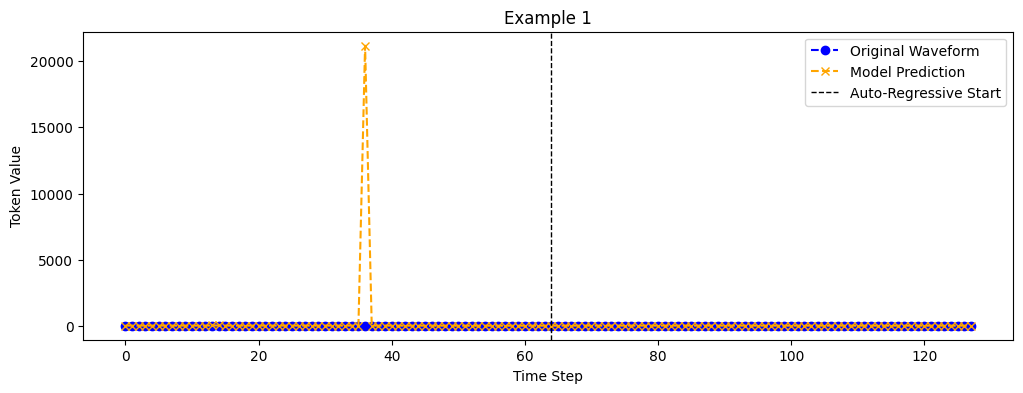

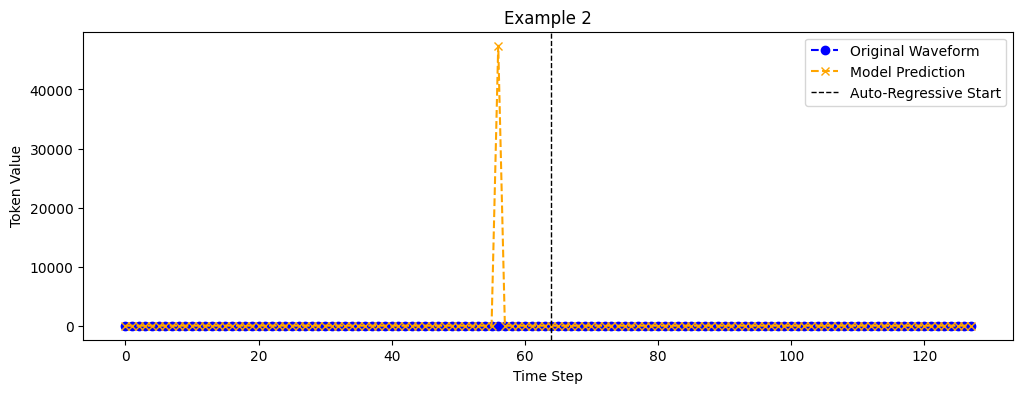

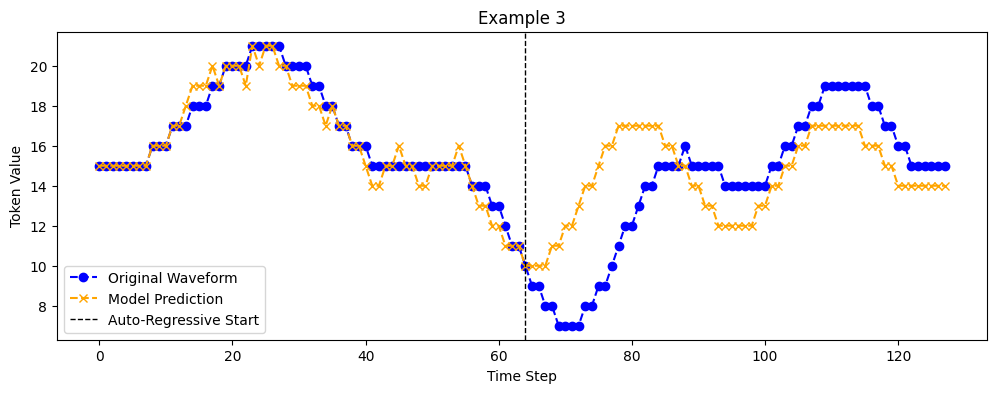

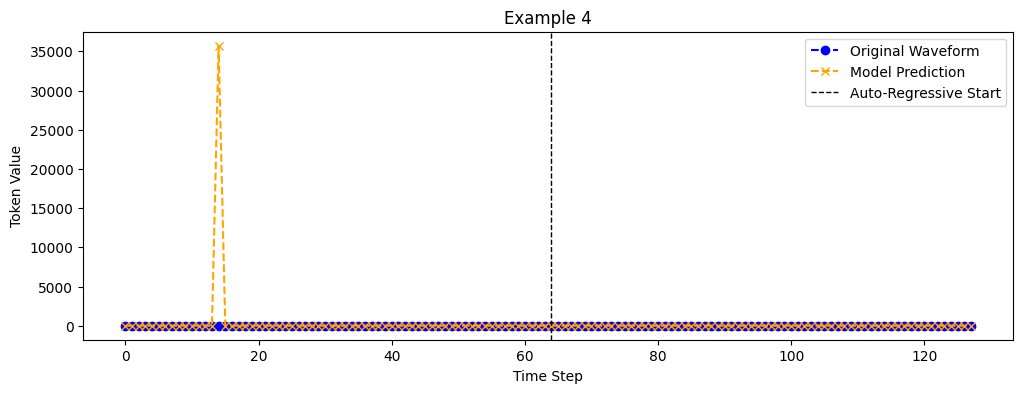

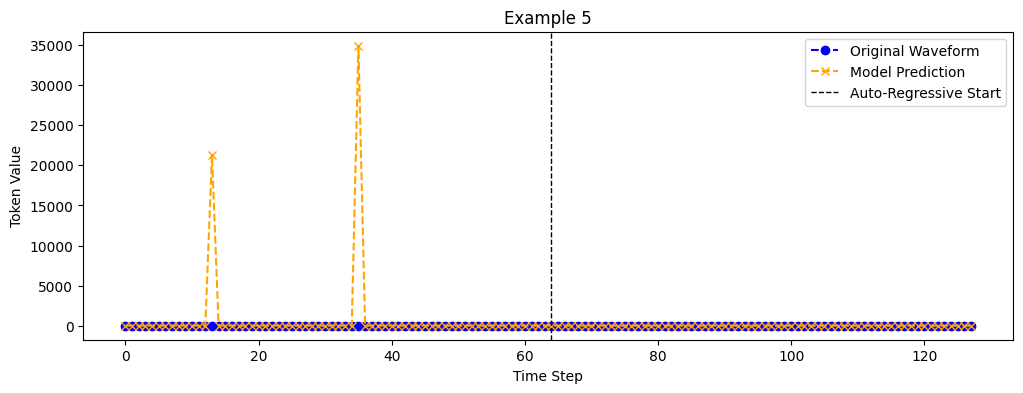

In [196]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch import Tensor

def plot_auto_regressive_predictions(model: nn.Module, data_loader: DataLoader, num_examples: int = 5) -> None:
    """
    Plot model predictions against actual values for multiple examples.
    The first half uses teacher-forcing, and the second half is auto-regressive.
    
    Args:
        model (nn.Module): Trained model to be evaluated.
        data_loader (DataLoader): DataLoader for the test dataset.
        num_examples (int): Number of examples to visualize.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model = model.to(device)

    # Get labeled sizes for readability
    batch_size = data_loader.batch_size or 1  # Set default in case batch_size=None
    seq_len = data_loader.dataset[0][0].shape[0]  # Sequence length from dataset
    vocab_size = model.config.padded_vocab_size  # Vocabulary size for model output
    auto_reg_start = seq_len // 2  # Point to start auto-regressive prediction

    # Fetch a single batch from the data loader
    with torch.no_grad():
        for batch in data_loader:
            tokens: Tensor = batch[0].to(device)
            assert tokens.shape == (batch_size, seq_len), f"Expected tokens of shape ({batch_size}, {seq_len}), got {tokens.shape}"
            break  # Only need one batch for visualization

    # Loop over examples to plot
    for i in range(min(num_examples, batch_size)):
        input_sequence = tokens[i]
        true_sequence = input_sequence.cpu().numpy()

        # Initialize prediction storage
        predictions = input_sequence.clone()
        
        # Teacher-forcing for the first half
        for t in range(auto_reg_start):
            outputs = model(predictions[:t + 1].unsqueeze(0))  # Shape: (1, t + 1, vocab_size)
            predicted_token = outputs[0, -1].argmax(dim=-1)  # Get the last time step's prediction
            predictions[t] = predicted_token  # Teacher-forcing, so we use ground truth next

        # Auto-regressive prediction for the second half
        for t in range(auto_reg_start, seq_len - 1):
            outputs = model(predictions[:t + 1].unsqueeze(0))  # Auto-regression
            predicted_token = outputs[0, -1].argmax(dim=-1)  # Predict the next token
            predictions[t + 1] = predicted_token  # Feed it back as input for the next step

        # Convert predictions to numpy for plotting
        predictions_np = predictions.cpu().numpy()

        # Plotting
        plt.figure(figsize=(12, 4))
        plt.plot(true_sequence, label="Original Waveform", marker="o", linestyle="--", color="blue")
        plt.plot(predictions_np, label="Model Prediction", marker="x", linestyle="--", color="orange")
        
        # Add dashed vertical line to indicate transition to auto-regression
        plt.axvline(x=auto_reg_start, color="black", linestyle="--", linewidth=1, label="Auto-Regressive Start")

        # Labels and legend
        plt.xlabel("Time Step")
        plt.ylabel("Token Value")
        plt.title(f"Example {i + 1}")
        plt.legend()
        plt.show()

plot_auto_regressive_predictions(model, test_loader, num_examples=5)